# Time Series Forescasting

In [774]:
import pandas as pd
from pandas import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [775]:
df=pd.read_csv('Itsm_data.csv',index_col=0)
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [776]:
#request fro info is not an incident
time=df.iloc[~df.index.isin(df.index[df.Category=='request for information'].to_list())]

In [777]:
# taking only relevant columns
time=time.loc[:,['Open_Time','Incident_ID']]

In [778]:
#coverting to timestampe
time.Open_Time=pd.to_datetime(time.Open_Time)


In [779]:
# removing time from timestamp
time.Open_Time=time['Open_Time'].dt.date

In [780]:
# grouping by dates
time=time.groupby('Open_Time').count()
time=time.reset_index()

In [781]:
time.rename(columns={'Incident_ID':'No_of_Incidents'},inplace=True)
time.head()

,Open_Time,No_of_Incidents
0,2012-01-10,1
1,2012-02-10,1
2,2012-03-09,1
3,2012-05-02,1
4,2012-05-12,1


In [782]:
time['Open_Time']=pd.to_datetime(time['Open_Time'])

In [783]:
time.head()

,Open_Time,No_of_Incidents
0,2012-01-10,1
1,2012-02-10,1
2,2012-03-09,1
3,2012-05-02,1
4,2012-05-12,1


In [784]:
print(time.index.min(),'to',time.index.max())

0 to 318


In [785]:
time.No_of_Incidents[1]

1

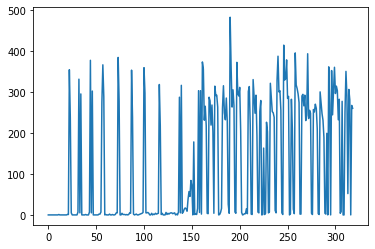

In [786]:
time.No_of_Incidents.plot()

Stationary means mean, variance and covariance is constant over periods.

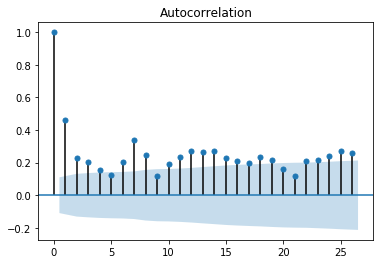

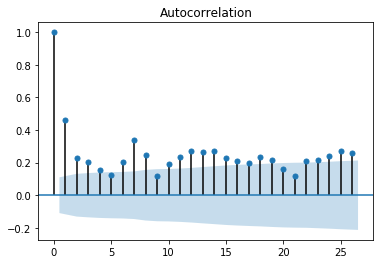

In [787]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(time.No_of_Incidents)


### Converting series to stationary

In [788]:
time.head()

,Open_Time,No_of_Incidents
0,2012-01-10,1
1,2012-02-10,1
2,2012-03-09,1
3,2012-05-02,1
4,2012-05-12,1


In [789]:
time.No_of_Incidents.shift(1)

0        NaN
1        1.0
2        1.0
3        1.0
4        1.0
       ...  
314     53.0
315    307.0
316    282.0
317      1.0
318    268.0
Name: No_of_Incidents, Length: 319, dtype: float64

In [790]:
time_diff = time.No_of_Incidents.diff(periods=1)
# integrated of order 1, denoted by d (for diff), one of the parameter of ARIMA model


In [791]:
time_diff = time_diff[1:]
time_diff.head()

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: No_of_Incidents, dtype: float64

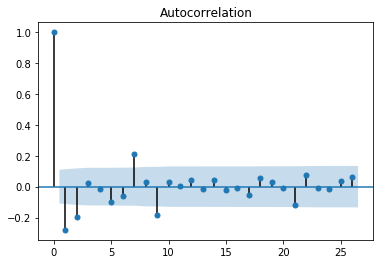

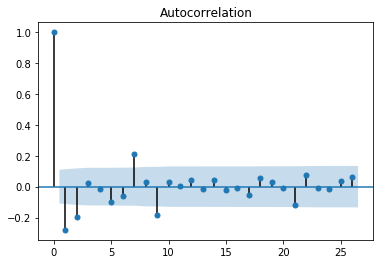

In [792]:
plot_acf(time_diff)

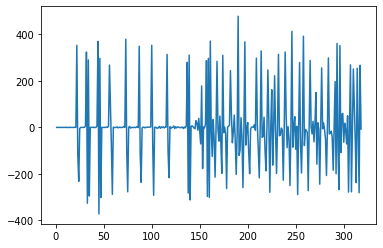

In [793]:
time_diff.plot()

In [794]:
X = time.No_of_Incidents.values
train = X[0:270] # 27 data as train data
test = X[269:]  # 9 data as test data
predictions = []

In [795]:
train.size

270

# Autoreggresive AR Model

In [796]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

In [797]:
predictions = model_ar_fit.predict(start=269,end=360)

In [798]:
test

array([231, 244, 394, 236, 256, 249,   5,   2, 258, 252, 271, 261, 211,
         4,   2, 301, 273, 248, 232, 189,   5,   3, 200,   1, 362, 269,
         1, 353, 245, 301, 361, 297, 315, 304, 233, 283,   5,   9, 278,
         1,   1, 252, 351, 291,  53, 307, 282,   1, 268, 261])

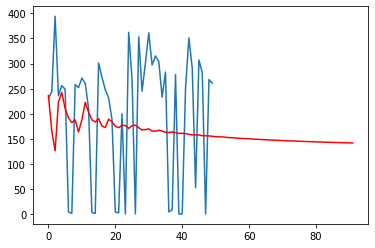

In [799]:
plt.plot(test)
plt.plot(predictions,color='red')

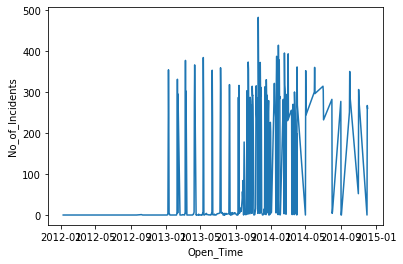

In [800]:

sns.lineplot(x="Open_Time", y="No_of_Incidents",legend = 'full' , data=time)

# ARIMA model

In [801]:
from statsmodels.tsa.arima_model import ARIMA

In [802]:
#p,d,q  p = periods taken for autoregressive model
#d -> Integrated order, difference
# q periods in moving average model
model_arima = ARIMA(train,order=(9, 2, 0))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

3412.254446500636


In [803]:
predictions= model_arima_fit.forecast(steps=50)[0]
predictions

array([146.71926474, 132.45348892, 238.6577608 , 252.07999725,
       248.29736555, 273.50526817, 242.72664927, 200.31540572,
       197.29453894, 231.05964542, 245.46360234, 246.8269478 ,
       262.53733359, 250.62736207, 230.90967583, 230.16762264,
       241.3649822 , 249.06209669, 253.45546698, 261.50783555,
       258.80327367, 250.21790888, 250.41934218, 254.59960086,
       258.57056823, 262.62977166, 267.34112112, 267.71546024,
       265.00318678, 265.56046401, 267.83306944, 270.17053123,
       273.34819917, 276.54159201, 277.92952839, 277.88987475,
       278.89138973, 280.63223769, 282.47999053, 284.94684256,
       287.44971885, 289.14927103, 290.25037879, 291.61140694,
       293.26655478, 295.01302119, 297.10567395, 299.26430611,
       301.0755518 , 302.63662739])

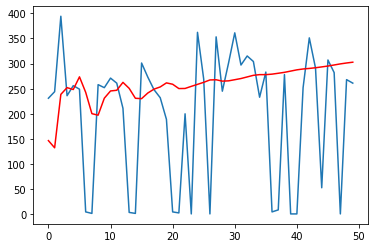

In [804]:
plt.plot(test)
plt.plot(predictions,color='red')

In [805]:
mean_squared_error(test,predictions)

20728.38369209586

In [806]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 0, 4),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 0),
 (1, 3, 1),
 (1, 3, 2),
 (1, 3, 3),
 (1, 3, 4),
 (1, 4, 0),
 (1, 4, 1),
 (1, 4, 2),
 (1, 4, 3),
 (1, 4, 4),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 0, 4),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 3, 0),
 (2, 3, 1),
 (2, 3, 2),
 (2, 3, 3),
 (2, 3, 4),
 (2, 4, 0),
 (2, 4, 1),
 (2, 4, 2),
 (2, 4, 3),
 (2, 4, 4),
 (3, 0, 0),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 0, 4),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3,

In [807]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        print(param,model_arima_fit.aic)
    except:
        continue
    

(0, 0, 0) 3437.3026485000523
(0, 0, 1) 3382.0797867277547
(0, 0, 2) 3375.48681449513
(0, 0, 3) 3376.929260884646
(0, 0, 4) 3375.443714815677
(0, 1, 0) 3438.6955608513467
(0, 1, 1) 3368.7688017797464
(0, 1, 2) 3340.0125926612227
(0, 1, 3) 3340.444972433799
(0, 1, 4) 3341.6989486838283
(0, 2, 0) 3675.538079118591
(0, 2, 1) 3434.5196925449854
(0, 2, 2) 3370.048813532103
(0, 2, 3) 3342.328037723547
(0, 2, 4) 3342.935431807882
(1, 0, 0) 3370.9571384811397
(1, 0, 1) 3372.9571384489177
(1, 0, 2) 4663.883109858543
(1, 1, 0) 3421.2203415423683
(1, 1, 1) 3340.5867441361743
(1, 1, 2) 3340.768228867614
(1, 1, 3) 3342.390261753626
(1, 1, 4) 3343.6098507968327
(1, 2, 0) 3586.628492936562
(2, 0, 0) 3372.9571384476485
(2, 0, 1) 3462.5195907708217
(2, 0, 2) 3679.1736199797324
(2, 0, 3) 3432.468402993995
(2, 0, 4) 3896.842191971913
(2, 1, 0) 3404.742649065841
(2, 1, 1) 3340.3473137420415
(2, 1, 2) 3341.855257254423
(2, 1, 3) 3342.687003635767
(2, 1, 4) 3341.801509591037
(2, 2, 0) 3538.7226207704007
(3, 

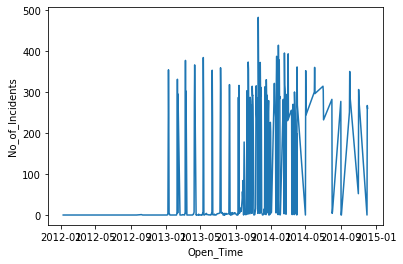

In [808]:
sns.lineplot(x="Open_Time", y="No_of_Incidents",legend = 'full' , data=time)

<Figure size 432x288 with 0 Axes>

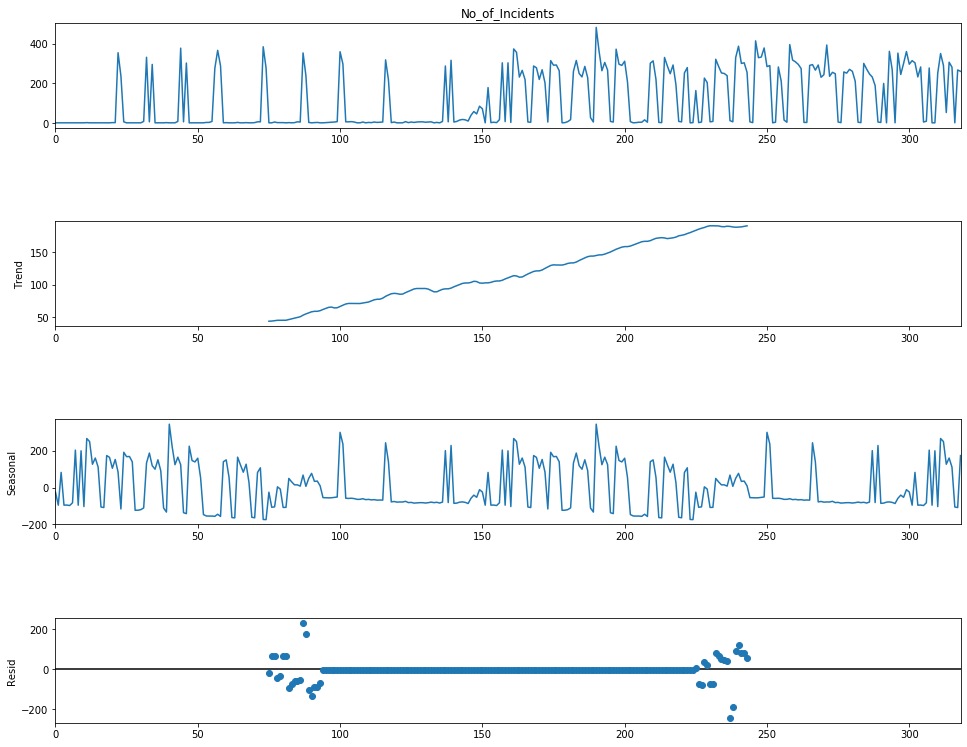

In [809]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time['No_of_Incidents'], model='additive', freq=150)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [810]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

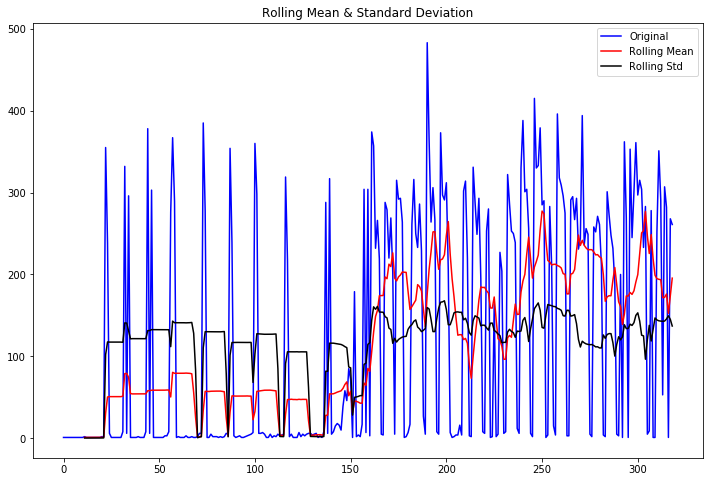

Results of Dickey-Fuller Test:
p-value = 0.1272. The series is likely non-stationary.
Test Statistic                  -2.453691
p-value                          0.127152
#Lags Used                      11.000000
Number of Observations Used    307.000000
Critical Value (1%)             -3.451831
Critical Value (5%)             -2.871001
Critical Value (10%)            -2.571811
dtype: float64


In [811]:
test_stationarity(time['No_of_Incidents'])

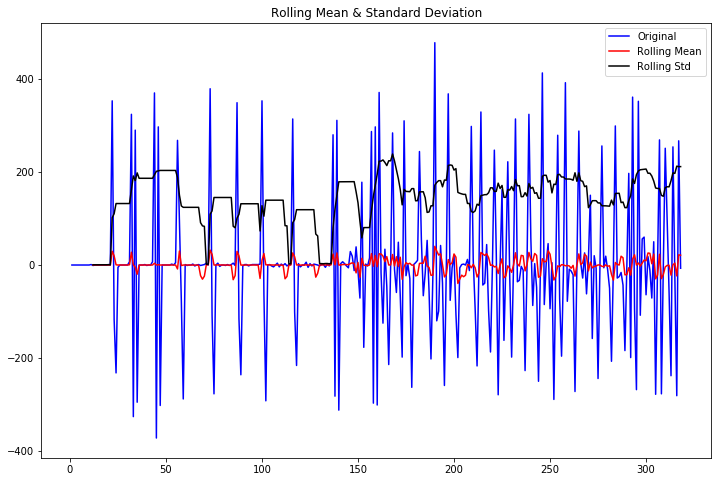

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.010858e+01
p-value                        1.014451e-17
#Lags Used                     1.000000e+01
Number of Observations Used    3.070000e+02
Critical Value (1%)           -3.451831e+00
Critical Value (5%)           -2.871001e+00
Critical Value (10%)          -2.571811e+00
dtype: float64


In [812]:
first_diff = time.No_of_Incidents - time.No_of_Incidents.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)


In [813]:
arima_mod6 = sm.tsa.ARIMA(time.No_of_Incidents, (4,1,0)).fit(disp=False)
print(arima_mod6.summary())

                             ARIMA Model Results                              
Dep. Variable:      D.No_of_Incidents   No. Observations:                  318
Model:                 ARIMA(4, 1, 0)   Log Likelihood               -2002.995
Method:                       css-mle   S.D. of innovations            131.512
Date:                Mon, 10 Aug 2020   AIC                           4017.991
Time:                        00:13:29   BIC                           4040.563
Sample:                             1   HQIC                          4027.006
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.6917      3.338      0.207      0.836      -5.851       7.234
ar.L1.D.No_of_Incidents    -0.4355      0.055     -7.861      0.000      -0.544      -0.327


NormaltestResult(statistic=20.50774071375772, pvalue=3.522091918416562e-05)


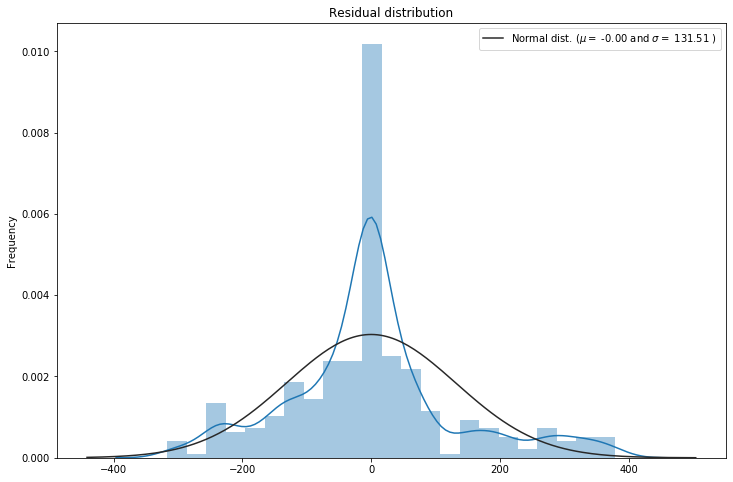

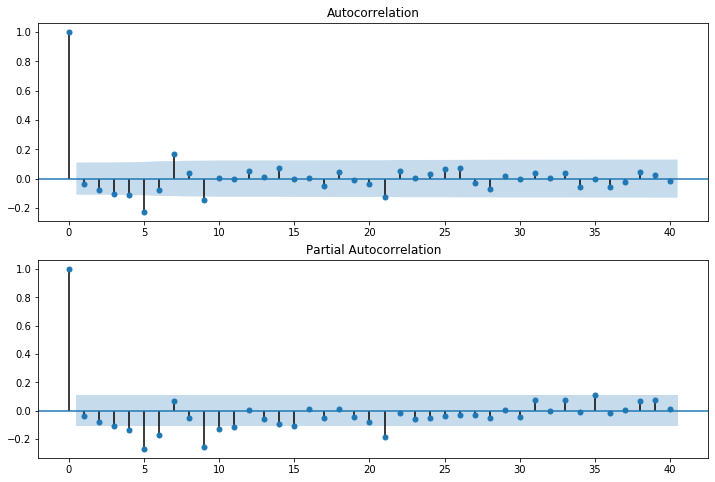

In [814]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [815]:
# will be more accurate if we reduce standard deviation, remove outliers. less variation reduces standard deviation

# Sarima model

In [816]:
from scipy import stats
from scipy.stats import normaltest

In [817]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(time.No_of_Incidents, trend='n', order=(4,1,0)).fit()
print(sarima_mod6.summary())

                               SARIMAX Results                                
Dep. Variable:        No_of_Incidents   No. Observations:                  319
Model:               SARIMAX(4, 1, 0)   Log Likelihood               -2003.027
Date:                Mon, 10 Aug 2020   AIC                           4016.055
Time:                        00:13:43   BIC                           4034.865
Sample:                             0   HQIC                          4023.568
                                - 319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4354      0.058     -7.464      0.000      -0.550      -0.321
ar.L2         -0.4111      0.055     -7.430      0.000      -0.520      -0.303
ar.L3         -0.2201      0.066     -3.353      0.0

In [820]:
resid = sarima_mod6.resid
print(normaltest(time))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'Timestamp'

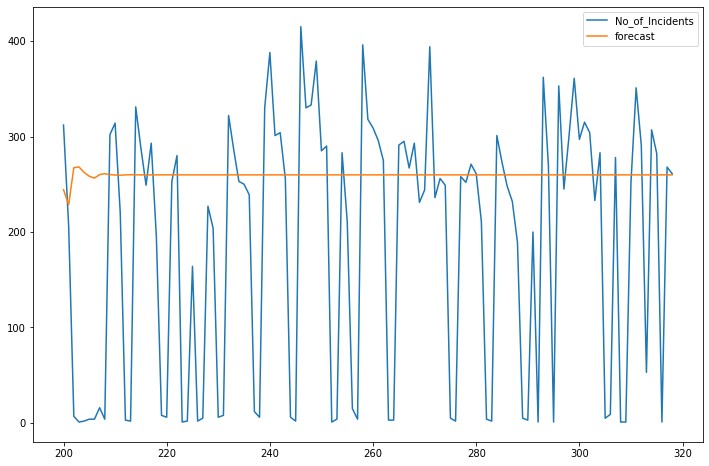

In [821]:
start_index = 200
end_index = 400
time['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
time[start_index:end_index][['No_of_Incidents', 'forecast']].plot(figsize=(12, 8))

In [822]:
time.head()

,Open_Time,No_of_Incidents,forecast
0,2012-01-10,1,NaN
1,2012-02-10,1,NaN
2,2012-03-09,1,NaN
3,2012-05-02,1,NaN
4,2012-05-12,1,NaN


In [823]:
exog_data = time['No_of_Incidents']
exog_data = time.set_index('Open_Time')
exog_data.head()

,No_of_Incidents,forecast
Open_Time,,
2012-01-10,1,NaN
2012-02-10,1,NaN
2012-03-09,1,NaN
2012-05-02,1,NaN
2012-05-12,1,NaN


In [824]:
start_index = '2017-10-01'
end_index = '2017-12-31'
# exog_data.head()


In [825]:
%%time
sarimax_mod6 = sm.tsa.statespace.SARIMAX(endog = time.No_of_Incidents[:start_index],exog = exog_data[:start_index],  trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod6.summary())

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [2017-10-01] of <class 'str'>

In [826]:
sarimax_mod6.forecast(steps = 121,exog = exog_data[start_index:end_index])

NameError: name 'sarimax_mod6' is not defined

In [827]:
time['forecast'] = sarimax_mod6.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),exog = exog_data[start_index:end_index],dynamic= True)  

time[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

NameError: name 'sarimax_mod6' is not defined